# MLP
Mean RCI over 14 cell lines.

This notebook uses
mRNA, all transcripts, no middle-exclusion train, no middle-exclusion test, 0 threshold, learning module, cross-validation.

In [1]:
SEED = 45
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 21:12:06.134226


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP_mRNA'
SAVE_DESCRIM_FILENAME = None # 'GMM_mRNA'
LOAD_MODEL_FILENAME = None # 'MLP_mRNA.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM_mRNA.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = 0  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -1   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         =  1   #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.pc_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.all_pc_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.all_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 21:12:08.163771
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.all_cell_lines.csv
Number of RCI values loaded 13663
Num RCI: 13663
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13663 sequences.

Training # 1 1
2023-04-29 21:13:03.309521
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5766:5164 52.75%
Computed class weights: {0: 1.058288148721921, 1: 0.947797433229275}
Valid 1:0 1402:1331 51.30%
FIT


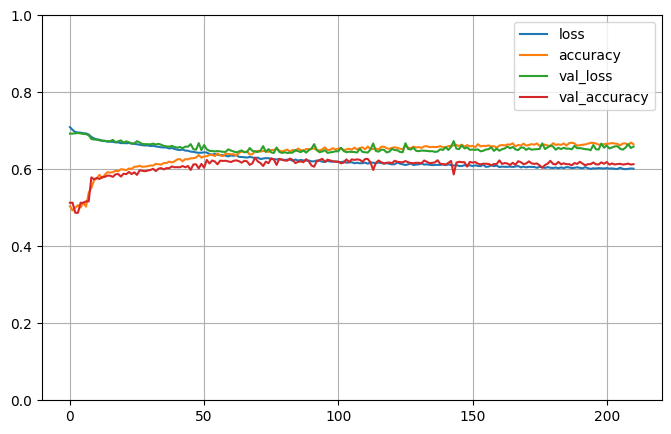

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.1.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.1.1.pickle

Testing # 1 1
2023-04-29 21:19:01.594123
PREDICT
Test 1:0 1402:1331 51.30%
Predict 1:0 1368:1365 50.05%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.51135993 mean 0.1778114 std
Range of scores: 0.1357053 to 0.977566
Score threshold 0.5
Confusion matrix
 [[838 493]
 [527 875]]
Normalized matrix
 [[0.30662276 0.18038785]
 [0.19282839 0.320161  ]]
Extreme scores correct, pos:neg 470 409
Extreme scores incorrect pos:neg 184 190


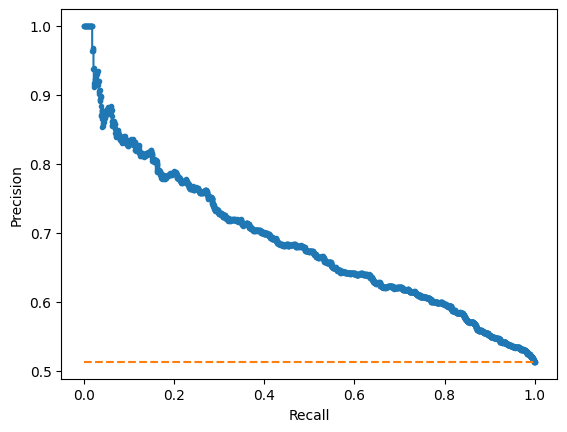

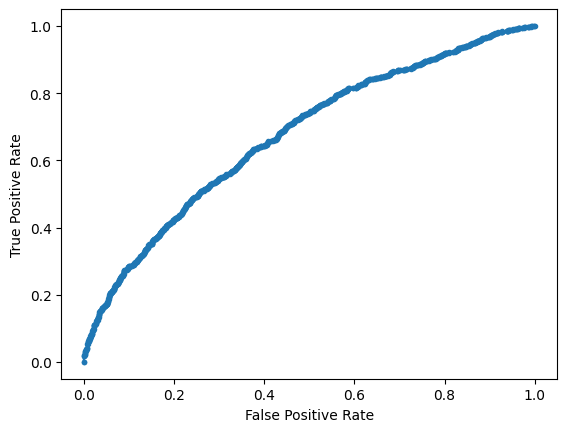

Accuracy: 62.68% Precision: 63.96% Recall: 62.41%
F1: 63.18% MCC: 0.2536
AUPRC: 68.62% AUROC: 67.48%
 accuracy [62.67837541163557]
 precision [63.961988304093566]
 recall [62.41084165477889]
 F1 [63.1768953068592]
 MCC [0.2536247439333026]
 AUPRC [68.6240805415902]
 AUROC [67.4815199066269]

Training # 1 2
2023-04-29 21:19:02.665075
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5693:5237 52.09%
Computed class weights: {0: 1.0435363757876648, 1: 0.9599508167925522}
Valid 1:0 1475:1258 53.97%
FIT


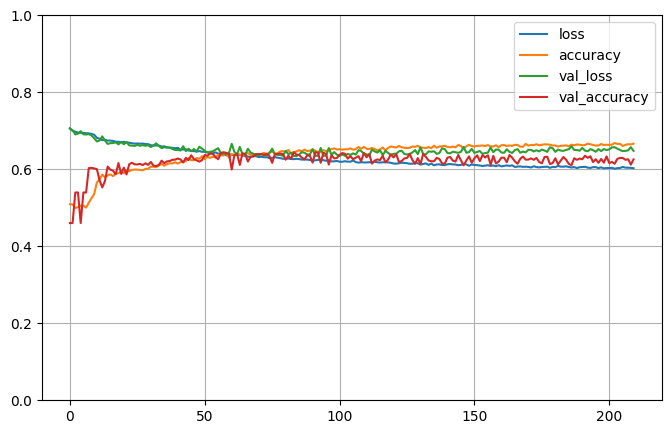

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.1.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.1.2.pickle

Testing # 1 2
2023-04-29 21:25:28.507463
PREDICT
Test 1:0 1475:1258 53.97%
Predict 1:0 1730:1003 63.30%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.57244694 mean 0.19187914 std
Range of scores: 0.11776113 to 0.99359065
Score threshold 0.5
Confusion matrix
 [[ 642  616]
 [ 361 1114]]
Normalized matrix
 [[0.2349067  0.22539334]
 [0.13208928 0.40761068]]
Extreme scores correct, pos:neg 725 288
Extreme scores incorrect pos:neg 306 128


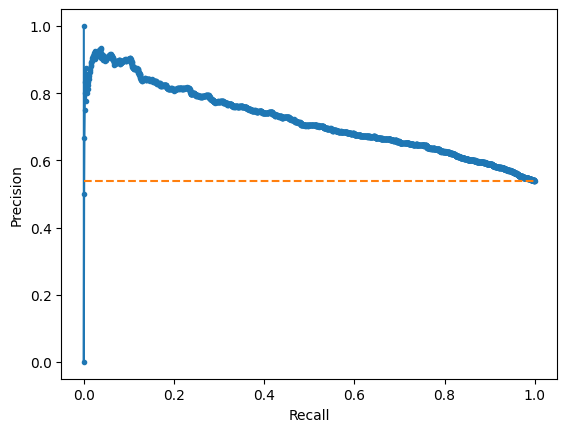

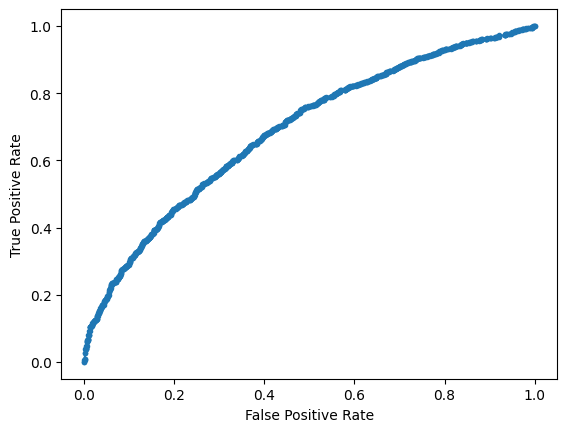

Accuracy: 64.25% Precision: 64.39% Recall: 75.53%
F1: 69.52% MCC: 0.2746
AUPRC: 71.80% AUROC: 68.77%
 accuracy [64.25173801683131]
 precision [64.39306358381502]
 recall [75.52542372881355]
 F1 [69.5163806552262]
 MCC [0.2746448283902345]
 AUPRC [71.79841908134034]
 AUROC [68.77340950122606]

Training # 1 3
2023-04-29 21:25:29.337143
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5720:5210 52.33%
Computed class weights: {0: 1.0489443378119, 1: 0.9554195804195804}
Valid 1:0 1448:1285 52.98%
FIT


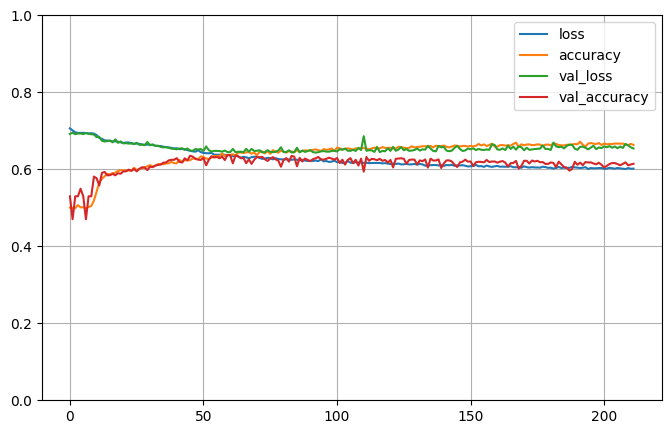

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.1.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.1.3.pickle

Testing # 1 3
2023-04-29 21:31:53.995772
PREDICT
Test 1:0 1448:1285 52.98%
Predict 1:0 1592:1141 58.25%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.547541 mean 0.18930392 std
Range of scores: 0.12317875 to 0.9768948
Score threshold 0.5
Confusion matrix
 [[ 710  575]
 [ 431 1017]]
Normalized matrix
 [[0.25978778 0.21039151]
 [0.15770216 0.37211855]]
Extreme scores correct, pos:neg 617 331
Extreme scores incorrect pos:neg 251 162


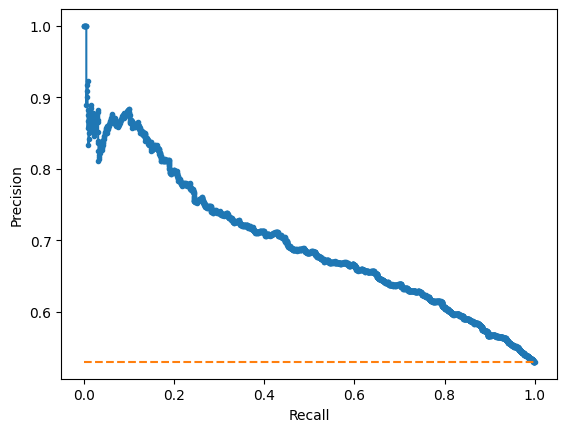

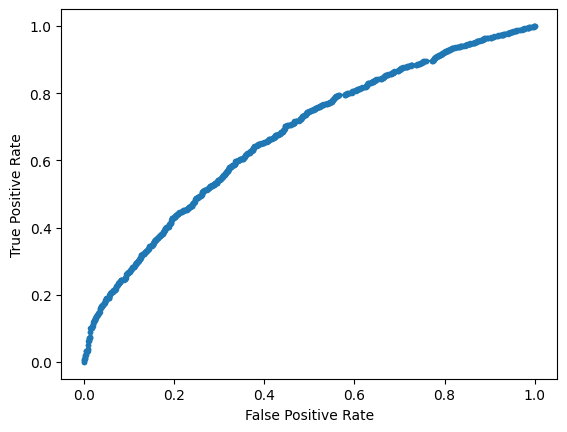

Accuracy: 63.19% Precision: 63.88% Recall: 70.23%
F1: 66.91% MCC: 0.2580
AUPRC: 69.72% AUROC: 67.42%
 accuracy [63.190633004024875]
 precision [63.881909547738694]
 recall [70.23480662983425]
 F1 [66.90789473684211]
 MCC [0.25796011514005335]
 AUPRC [69.72249220193531]
 AUROC [67.41957241438612]

Training # 1 4
2023-04-29 21:31:54.845507
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5770:5161 52.79%
Computed class weights: {0: 1.059000193760899, 1: 0.9472270363951473}
Valid 1:0 1398:1334 51.17%
FIT


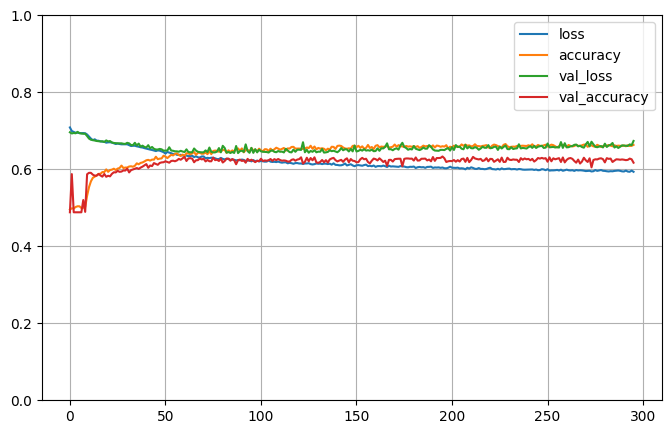

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.1.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.1.4.pickle

Testing # 1 4
2023-04-29 21:40:16.196354
PREDICT
Test 1:0 1398:1334 51.17%
Predict 1:0 1124:1608 41.14%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.4810249 mean 0.18524939 std
Range of scores: 0.09995596 to 0.9945966
Score threshold 0.5
Confusion matrix
 [[970 364]
 [638 760]]
Normalized matrix
 [[0.35505124 0.13323572]
 [0.23352855 0.27818448]]
Extreme scores correct, pos:neg 360 483
Extreme scores incorrect pos:neg 108 226


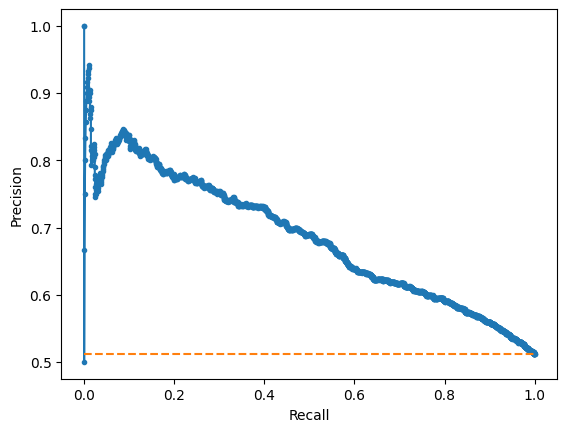

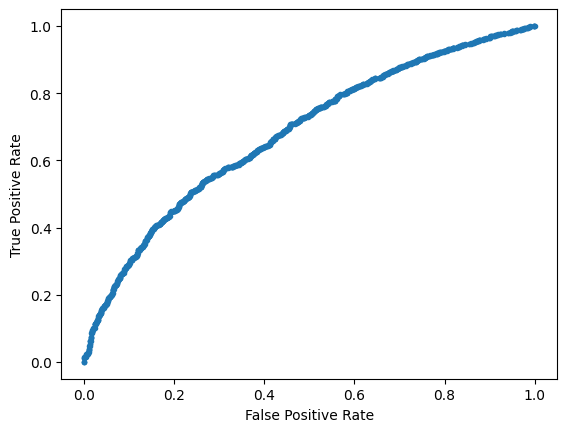

Accuracy: 63.32% Precision: 67.62% Recall: 54.36%
F1: 60.27% MCC: 0.2750
AUPRC: 68.37% AUROC: 68.01%
 accuracy [63.32357247437774]
 precision [67.61565836298932]
 recall [54.36337625178827]
 F1 [60.26962727993656]
 MCC [0.2750465357238468]
 AUPRC [68.37204851205124]
 AUROC [68.01328413046696]

Training # 1 5
2023-04-29 21:40:17.067347
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5723:5208 52.36%
Computed class weights: {0: 1.0494431643625193, 1: 0.9550061156735977}
Valid 1:0 1445:1287 52.89%
FIT


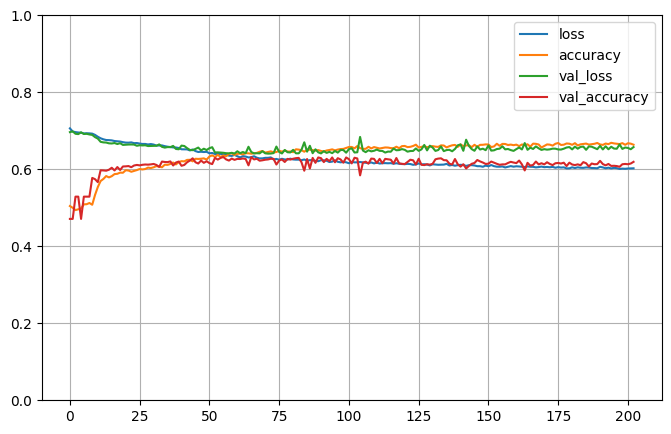

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.1.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.1.5.pickle

Testing # 1 5
2023-04-29 21:46:18.226428
PREDICT
Test 1:0 1445:1287 52.89%
Predict 1:0 1498:1234 54.83%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5280459 mean 0.180061 std
Range of scores: 0.12897728 to 0.98829865
Score threshold 0.5
Confusion matrix
 [[755 532]
 [479 966]]
Normalized matrix
 [[0.27635432 0.19472914]
 [0.17532943 0.35358712]]
Extreme scores correct, pos:neg 540 355
Extreme scores incorrect pos:neg 201 164


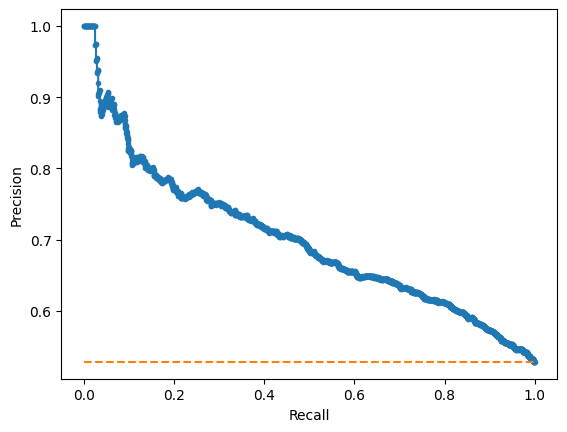

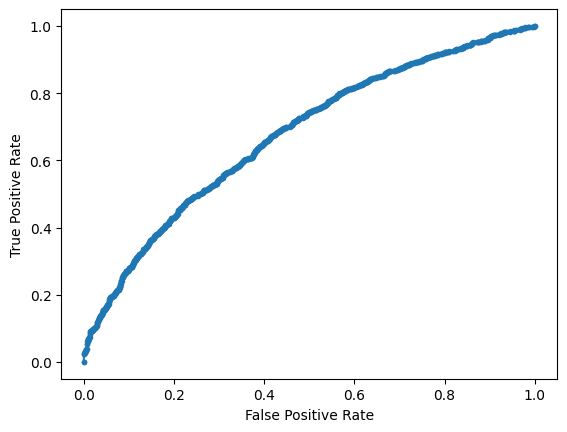

Accuracy: 62.99% Precision: 64.49% Recall: 66.85%
F1: 65.65% MCC: 0.2559
AUPRC: 69.90% AUROC: 67.56%
 accuracy [62.994143484626655]
 precision [64.48598130841121]
 recall [66.85121107266437]
 F1 [65.64729867482161]
 MCC [0.2559183127210742]
 AUPRC [69.90099323329777]
 AUROC [67.56207268317995]

Training # 2 1
2023-04-29 21:46:19.102156
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5739:5191 52.51%
Computed class weights: {0: 1.0527836640339048, 1: 0.9522564906778185}
Valid 1:0 1429:1304 52.29%
FIT


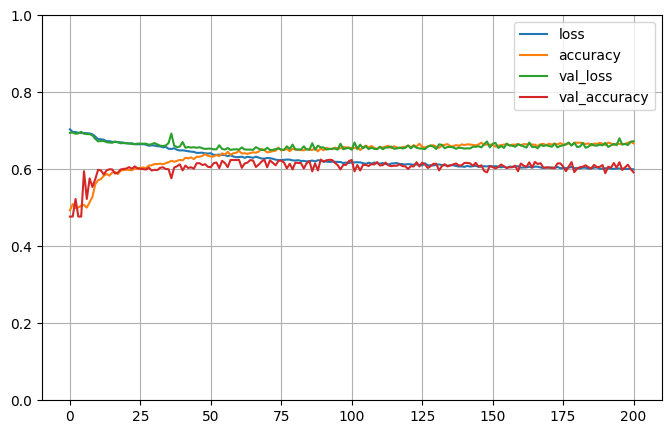

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.2.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.2.1.pickle

Testing # 2 1
2023-04-29 21:52:43.674159
PREDICT
Test 1:0 1429:1304 52.29%
Predict 1:0 1544:1189 56.49%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.53381425 mean 0.17500778 std
Range of scores: 0.1297988 to 0.98468333
Score threshold 0.5
Confusion matrix
 [[733 571]
 [456 973]]
Normalized matrix
 [[0.26820344 0.20892792]
 [0.16684962 0.35601903]]
Extreme scores correct, pos:neg 529 312
Extreme scores incorrect pos:neg 217 147


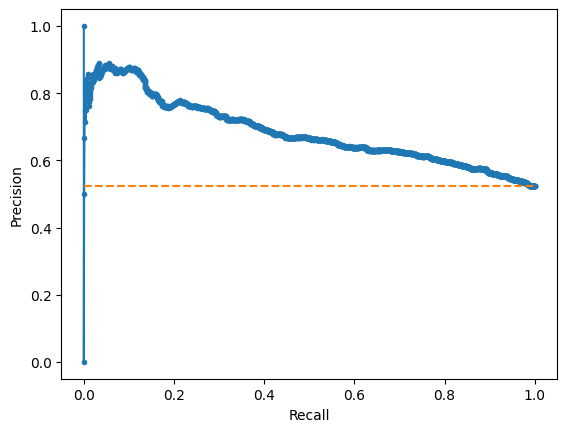

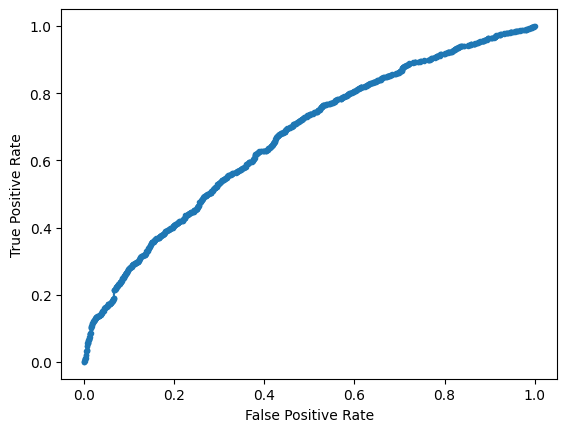

Accuracy: 62.42% Precision: 63.02% Recall: 68.09%
F1: 65.46% MCC: 0.2448
AUPRC: 68.31% AUROC: 66.67%
 accuracy [62.42224661544091]
 precision [63.01813471502591]
 recall [68.08957312806159]
 F1 [65.45576858392197]
 MCC [0.24483222699875556]
 AUPRC [68.31425090836274]
 AUROC [66.67233725587845]

Training # 2 2
2023-04-29 21:52:44.562994
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5748:5182 52.59%
Computed class weights: {0: 1.054612118873022, 1: 0.9507654836464857}
Valid 1:0 1420:1313 51.96%
FIT


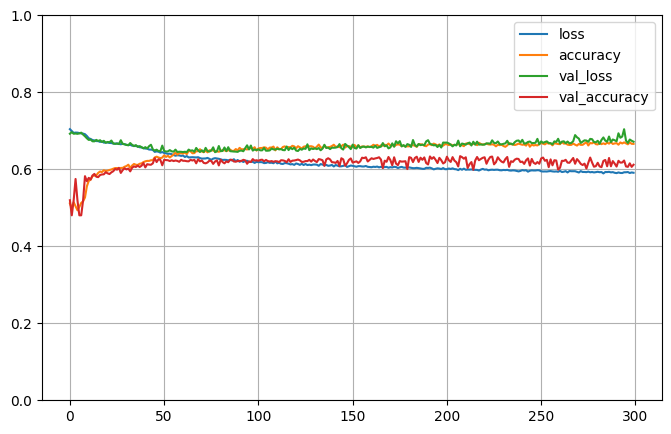

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.2.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.2.2.pickle

Testing # 2 2
2023-04-29 22:02:09.579259
PREDICT
Test 1:0 1420:1313 51.96%
Predict 1:0 1245:1488 45.55%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5176896 mean 0.20011765 std
Range of scores: 0.104656115 to 0.96954167
Score threshold 0.5
Confusion matrix
 [[870 443]
 [618 802]]
Normalized matrix
 [[0.3183315  0.16209294]
 [0.22612514 0.29345042]]
Extreme scores correct, pos:neg 433 359
Extreme scores incorrect pos:neg 178 187


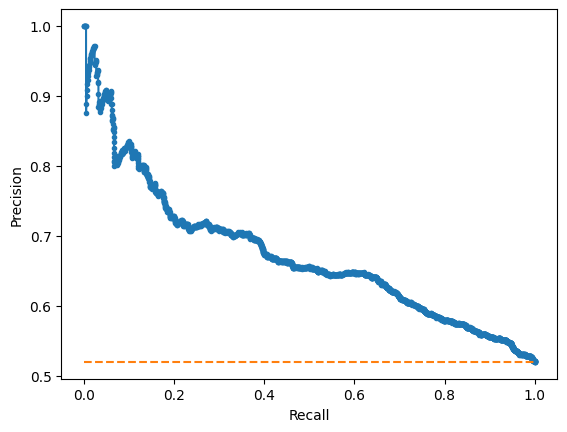

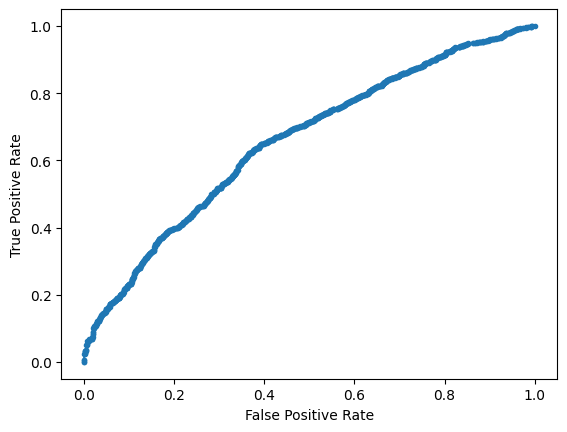

Accuracy: 61.18% Precision: 64.42% Recall: 56.48%
F1: 60.19% MCC: 0.2281
AUPRC: 67.25% AUROC: 65.65%
 accuracy [61.17819246249543]
 precision [64.41767068273091]
 recall [56.47887323943662]
 F1 [60.18761726078799]
 MCC [0.2281226212093026]
 AUPRC [67.24936154715353]
 AUROC [65.64753333404848]

Training # 2 3
2023-04-29 22:02:10.338474
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5690:5240 52.06%
Computed class weights: {0: 1.04293893129771, 1: 0.960456942003515}
Valid 1:0 1478:1255 54.08%
FIT


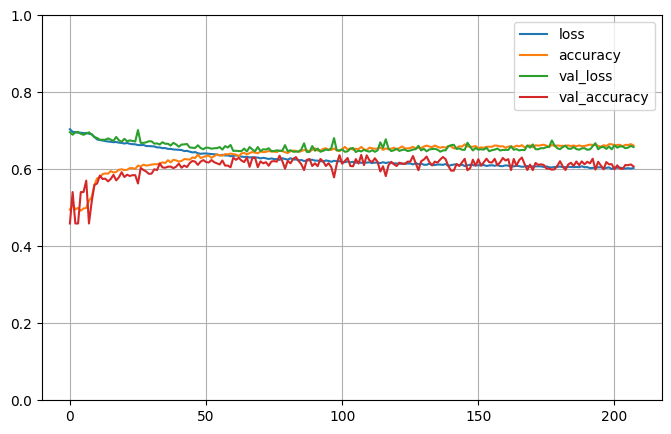

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.2.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.2.3.pickle

Testing # 2 3
2023-04-29 22:08:35.801731
PREDICT
Test 1:0 1478:1255 54.08%
Predict 1:0 1591:1142 58.21%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.55404943 mean 0.18514559 std
Range of scores: 0.13842185 to 0.98807794
Score threshold 0.5
Confusion matrix
 [[ 703  552]
 [ 439 1039]]
Normalized matrix
 [[0.25722649 0.20197585]
 [0.16062935 0.38016831]]
Extreme scores correct, pos:neg 633 302
Extreme scores incorrect pos:neg 259 126


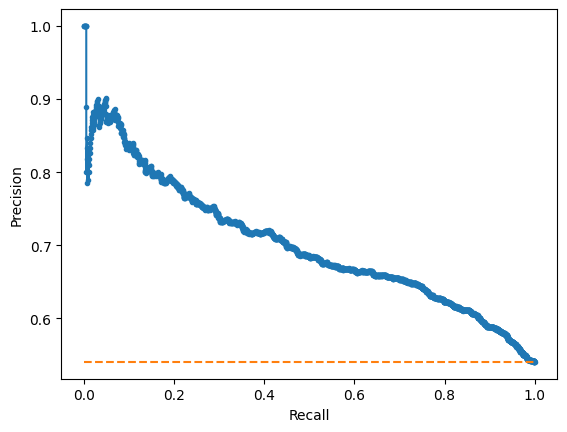

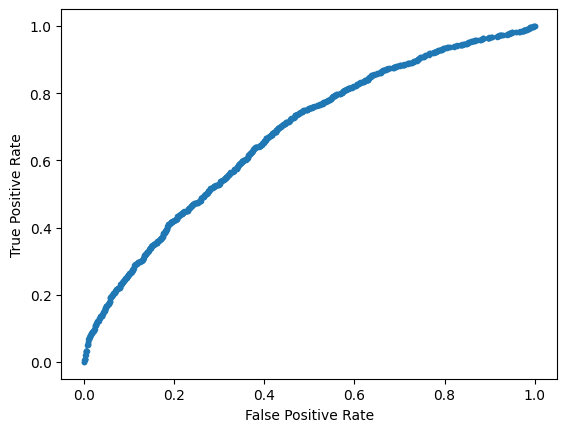

Accuracy: 63.74% Precision: 65.30% Recall: 70.30%
F1: 67.71% MCC: 0.2659
AUPRC: 70.14% AUROC: 67.60%
 accuracy [63.73948042444201]
 precision [65.30483972344437]
 recall [70.29769959404601]
 F1 [67.70935158031932]
 MCC [0.2658715077291913]
 AUPRC [70.14021724772527]
 AUROC [67.60209500293819]

Training # 2 4
2023-04-29 22:08:36.714510
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5718:5213 52.31%
Computed class weights: {0: 1.048436600805678, 1: 0.9558412032179083}
Valid 1:0 1450:1282 53.07%
FIT


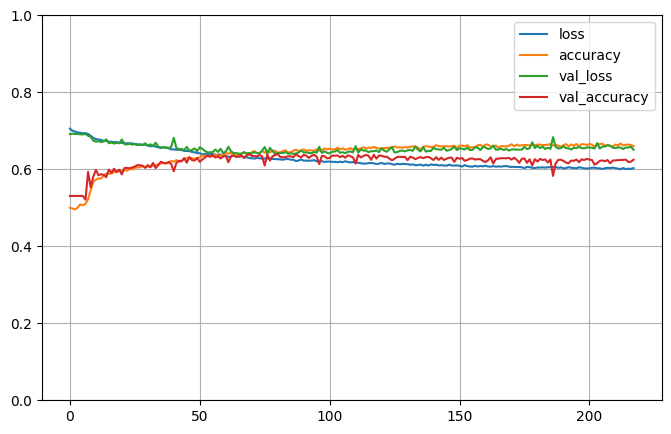

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.2.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.2.4.pickle

Testing # 2 4
2023-04-29 22:15:14.726154
PREDICT
Test 1:0 1450:1282 53.07%
Predict 1:0 1412:1320 51.68%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5117187 mean 0.19184075 std
Range of scores: 0.05472721 to 0.98776156
Score threshold 0.5
Confusion matrix
 [[806 476]
 [514 936]]
Normalized matrix
 [[0.29502196 0.17423133]
 [0.18814056 0.34260615]]
Extreme scores correct, pos:neg 492 404
Extreme scores incorrect pos:neg 172 223


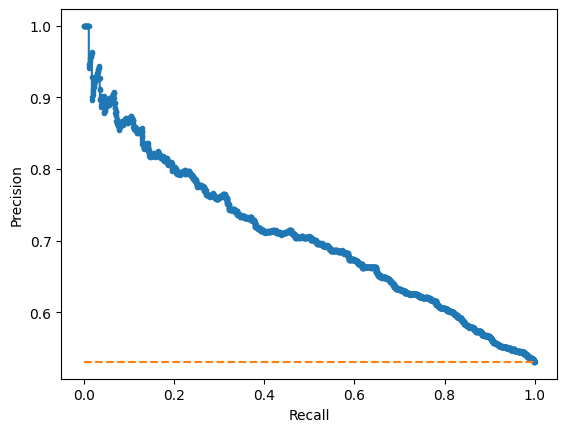

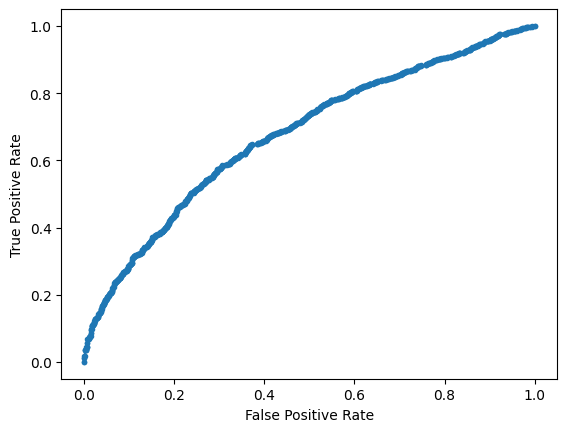

Accuracy: 63.76% Precision: 66.29% Recall: 64.55%
F1: 65.41% MCC: 0.2739
AUPRC: 70.60% AUROC: 67.59%
 accuracy [63.7628111273792]
 precision [66.28895184135978]
 recall [64.55172413793103]
 F1 [65.40880503144655]
 MCC [0.27385874318664566]
 AUPRC [70.59794655797546]
 AUROC [67.58986497390929]

Training # 2 5
2023-04-29 22:15:15.650526
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5777:5154 52.85%
Computed class weights: {0: 1.0604384943733023, 1: 0.9460792799030638}
Valid 1:0 1391:1341 50.92%
FIT


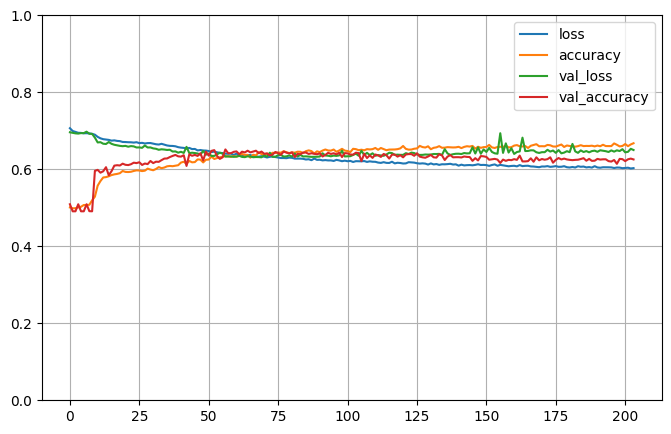

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_mRNA.2.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_mRNA.2.5.pickle

Testing # 2 5
2023-04-29 22:21:12.873475
PREDICT
Test 1:0 1391:1341 50.92%
Predict 1:0 1640:1092 60.03%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5569904 mean 0.18608536 std
Range of scores: 0.14427339 to 0.97966564
Score threshold 0.5
Confusion matrix
 [[ 729  612]
 [ 363 1028]]
Normalized matrix
 [[0.26683748 0.22401171]
 [0.13286969 0.37628111]]
Extreme scores correct, pos:neg 640 312
Extreme scores incorrect pos:neg 267 116


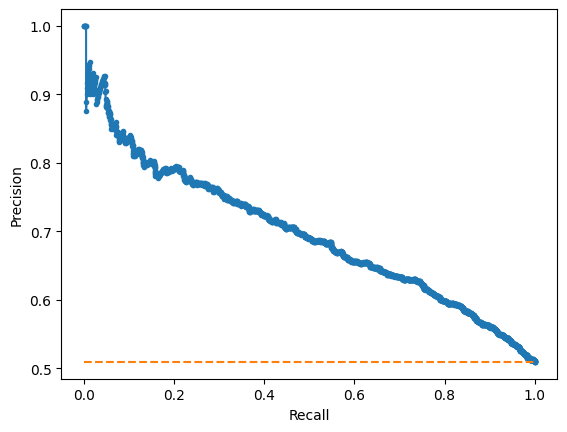

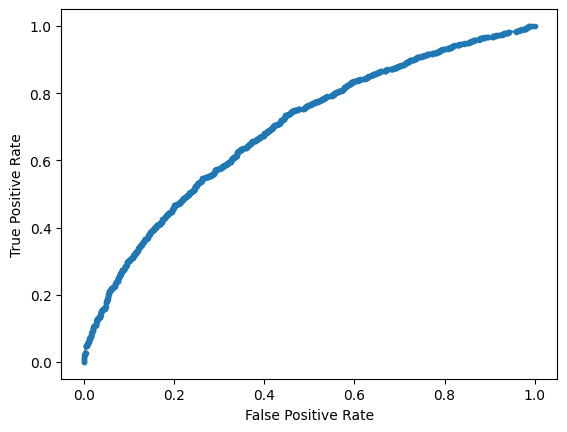

Accuracy: 64.31% Precision: 62.68% Recall: 73.90%
F1: 67.83% MCC: 0.2885
AUPRC: 69.60% AUROC: 69.32%
 accuracy [64.31185944363104]
 precision [62.68292682926829]
 recall [73.90366642703091]
 F1 [67.83239854833388]
 MCC [0.28847642905515525]
 AUPRC [69.6009952296415]
 AUROC [69.31539228158434]
2023-04-29 22:21:13.777684


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator('pc')  # use pc filename prefix for mRNA
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 63.19% std 0.94
 precision mean 64.61% std 1.48
 recall mean 66.27% std 6.95
 F1 mean 65.21% std 3.14
 MCC mean 0.2618 std 0.0175
 AUPRC mean 69.43% std 1.32
 AUROC mean 67.61% std 1.01
 accuracy [[62.67837541163557], [64.25173801683131], [63.190633004024875], [63.32357247437774], [62.994143484626655], [62.42224661544091], [61.17819246249543], [63.73948042444201], [63.7628111273792], [64.31185944363104]]
 precision [[63.961988304093566], [64.39306358381502], [63.881909547738694], [67.61565836298932], [64.48598130841121], [63.01813471502591], [64.41767068273091], [65.30483972344437], [66.28895184135978], [62.68292682926829]]
 recall [[62.41084165477889], [75.52542372881355], [70.23480662983425], [54.36337625178827], [66.85121107266437], [68.08957312806159], [56.47887323943662], [70.29769959404601], [64.55172413793103], [73.90366642703091]]
 F1 [[63.1768953068592], [69.5163806552262], [66.90789473684211], [60.26962727993656], [65.64729867482161], [65.45576858392197], [60.1